In [1]:
:ext TypeSynonymInstances
:ext FlexibleInstances

In [2]:
import Utils
import Data.Tuple.Extra (uncurry3, both, first, second, (***))
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd)
import Data.Ord (Down(..))
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM)
import Control.Monad.Trans.State
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate
import qualified System.Random.MWC.Probability as MWC
-- import Tyche.Inference.LikelihoodWeighting

In [4]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

# Setting Things Up

## The Model

Worlds are distinguished only by the height of the individual at issue (call him John)

In [5]:
data World = World {label :: String, ht :: Int} deriving Eq

instance Ord World where
  w <= w' = ht w <= ht w'

instance Show World where
  show (World l _) = l

But what we reason about are effectively **pointed distributions**, which include information about John's height *relative to other heights of individuals in the comparison class*

In [6]:
type Index = (World, Int)
instance {-# OVERLAPPING #-} Show Index where
  show (w,i) = show w ++ ";" ++ show i

A **proposition** is a set of these centered distributions

In [7]:
type Prop = [Index]

For the sake of computational efficiency, we imagine that there are only 11 possible heights

In [8]:
heights = [1 .. 11]
universe = [World ("j" ++ show h) h | h <- heights]

Again for efficiency's sake, not all world-center pairs are considered possible. The median height is assumed to fall between $4$ and $8$, and John's height is assumed to fall within $3$ steps of the median: 

\begin{equation} C_{\textsf{j}} \subseteq \Bigl\{\langle w, \mu\rangle \Bigm\vert 4 \leq \mu \leq 8,\ -3 \leq \mu - \textsf{ht}_{w}(\textsf{j}) \leq 3\Bigr\} \end{equation}

In [9]:
sigma = 3
indices = [(w, mu) | mu <- drop sigma . dropEnd sigma $ heights, w <- universe, abs (ht w - mu) <= sigma]
indices

[j1;4,j2;4,j3;4,j4;4,j5;4,j6;4,j7;4,j2;5,j3;5,j4;5,j5;5,j6;5,j7;5,j8;5,j3;6,j4;6,j5;6,j6;6,j7;6,j8;6,j9;6,j4;7,j5;7,j6;7,j7;7,j8;7,j9;7,j10;7,j5;8,j6;8,j7;8,j8;8,j9;8,j10;8,j11;8]

## The Language

We have a marked utterance, an unmarked utterance, and a null utterance (the least marked)

In [10]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances = [minBound .. maxBound]

A **lexicon** is a denotation function mapping utterances to propositions

In [11]:
data Lexicon = Lex {lexID :: Int, den :: Utt -> Prop}
instance Show Lexicon where
  show (Lex _ f) = "C = " ++ show (f UNone) ++ "; E = " ++ show (f UTall)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [12]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Lexicon) (Dist Index))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [13]:
data Priors = Priors {ip :: Model Index, up :: Model Utt, lp :: Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Lexicon) -> Model a
type AgentPlain k a = Priors -> (Int, k, Lexicon) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (its cost) and the likelihood that a listener would assign to $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would assign to $u$ upon trying to describe $i$

In [14]:
alpha :: Double
alpha = 4

speaker :: Agent Index Utt
speaker priors ref (n,i,l) =
  do u <- up priors
     if null (den l u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,l)
               weight $ alpha * logProb lnr i
     return u

listener :: Agent Utt (Index, Lexicon)
listener priors ref (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speaker priors ref (n,index,interp)
         observe spr u
         return (index, interp)
  | otherwise =
      do index  <- ip priors
         condition (index `elem` den l u)
         return (index, l)

In [15]:
{--
speakerPlain :: AgentPlain Index Utt
speakerPlain priors (n,i,l) =
  do u   <- up priors
     lnr <- lift $ enumD $ listenerPlain priors (n-1,u,l)
     weight $ alpha * logProb lnr i
     return u

listenerPlain :: AgentPlain Utt Index
listenerPlain priors (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speakerPlain priors (n,index,interp)
         observe spr u
         return index
  | otherwise =
      do index <- ip priors
         condition (index `elem` den l u)
         return index
--}

# Experiments

Prior belief about indices is that people are normally sized. That is, the median height is unknown, but whatever it is, the world where John has that height is more likely than the worlds where John is above it or below it.

In [16]:
indicesPriorFlat :: Model Index
indicesPriorFlat =
  do (w,i) <- unif indices
     observe (Normal 0 1.85) (fromIntegral $ ht w - i)
     return (w,i)

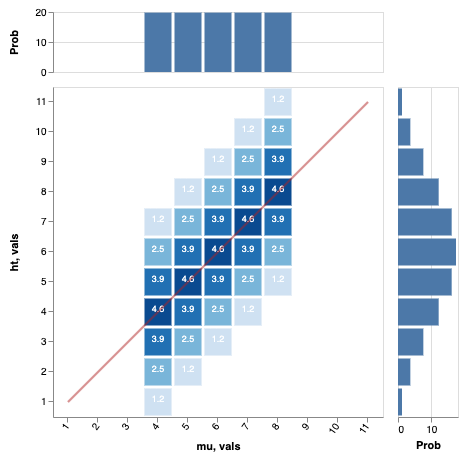

In [17]:
vlShow . margHeatFromDist <$> enumD (first ht <$> indicesPriorFlat)

Exogenous costs influence the prior likelihoods of utterances

In [18]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior1 :: Model Utt
utterancePrior1 = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

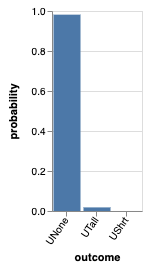

In [19]:
vlShow . barFromDist <$> enumD utterancePrior1

## Positive Utterances

Keeping all priors about indices and utterances the same, we now model pragmatic listeners who consider various strengthenings of the assertion (note that these are strengthenings in the *dynamic sense*; the pure informational content about John's height is the same in all lexica)

Baseline `den0` of both antonyms is that they are tautologies (John's height is within 2 steps of the median)

On other interpretations, 'Tall' (resp. 'Short') places John in a certain upper (resp. lower) percentile of the comparison class

\begin{align}
[\![\text{John is tall}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) \geq \mu + \sigma\\
[\![\text{John is short}]\!]_{\sigma} &:= \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) \leq \mu + \sigma
\end{align}

In [20]:
den0 :: Lexicon
den0 = Lex 0 f
  where f _ = indices

posDens :: [Lexicon]
posDens =
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w <= i + d) indices
     return (Lex d f)

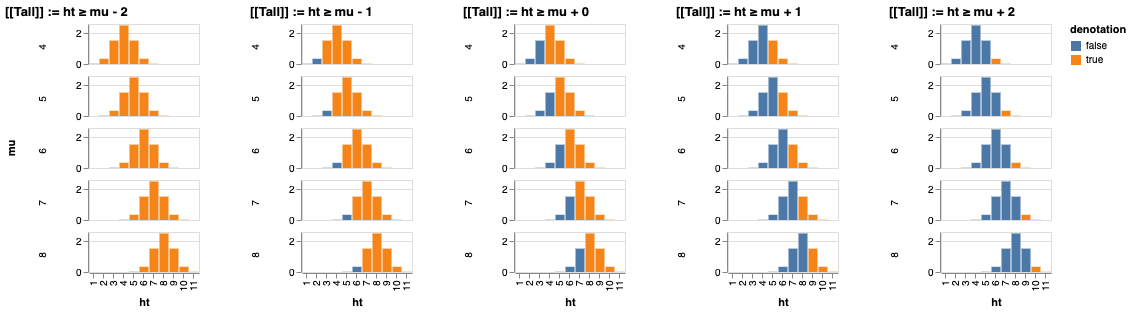

In [21]:
import IHaskell.Display (Display(..), javascript, vegalite)
import System.IO
readFile "posDens.vl" >>= \js -> pure (Display [vegalite js])

In [22]:
infoBaseline = Priors indicesPriorFlat utterancePrior1 (unif [den0])
infoLUM = infoBaseline {lp = unif posDens}

### Pragmatic agents

#### Pragmatic listener hears:

> "John is tall"

These agents become very confident that John's height exceeds the standard, though they remain in the dark about what the standard is

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height exceeds it leads to a (positively skewed) evaluative distribution over worlds

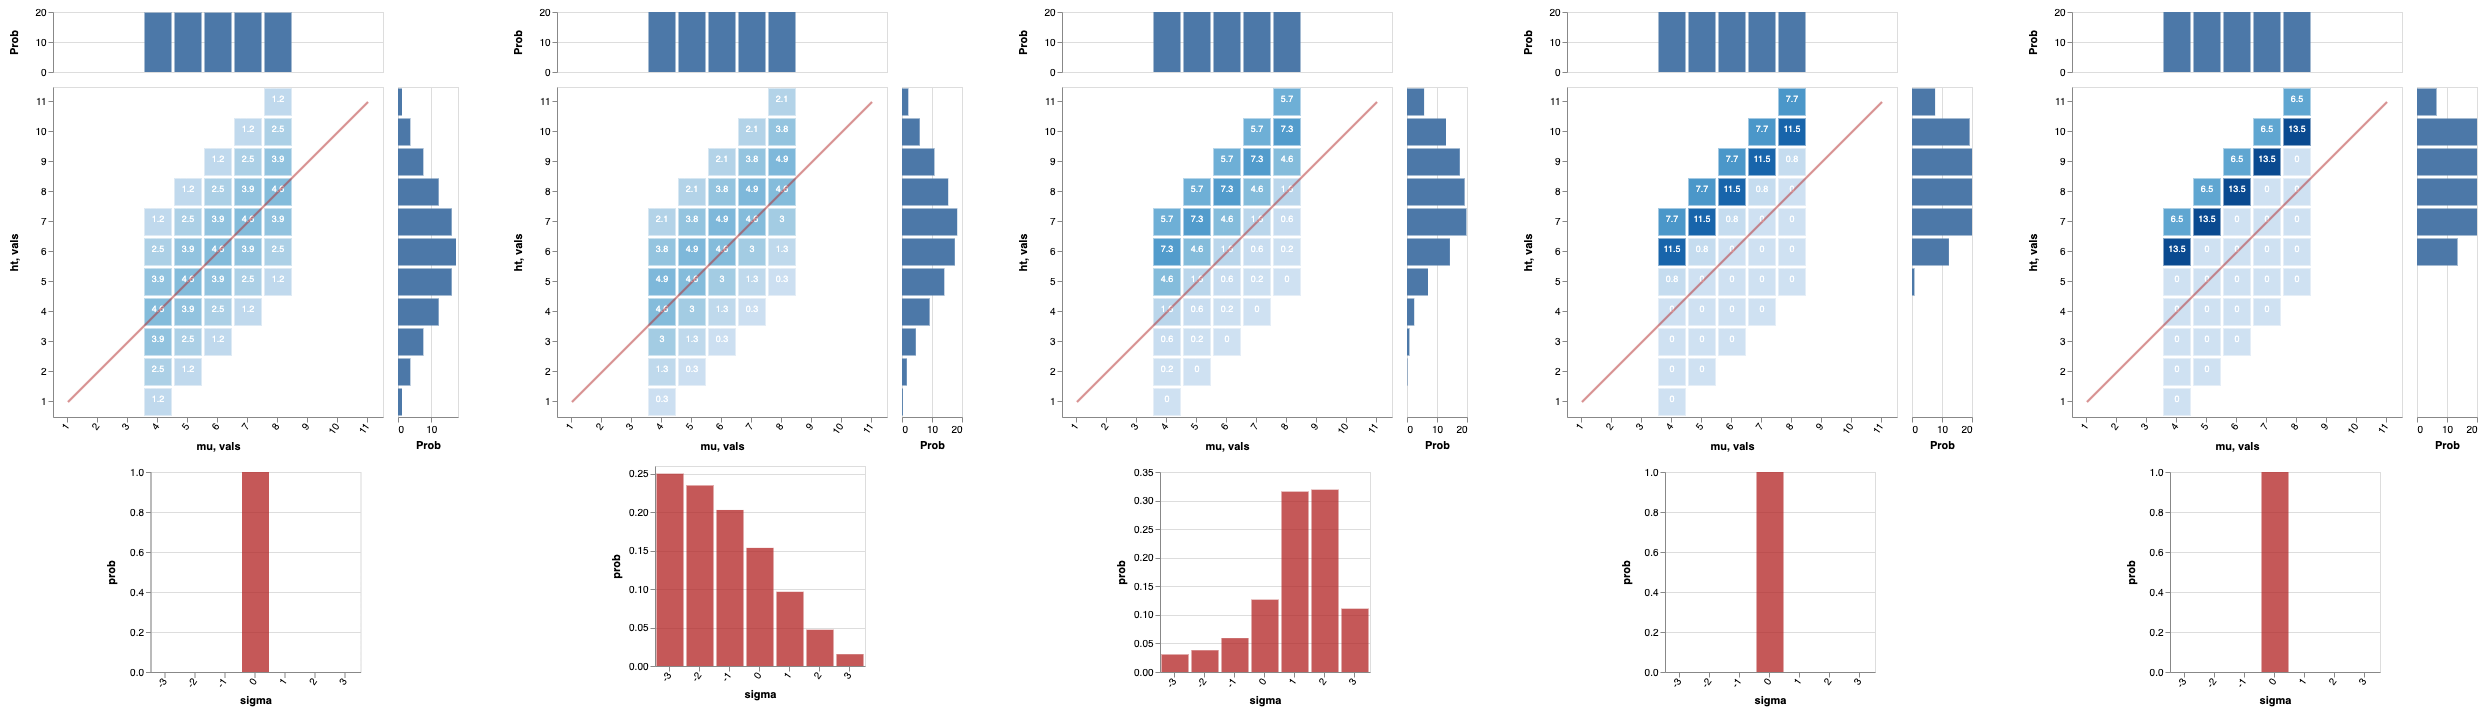

In [37]:
writeIORef cacheRef (0, Map.empty)

mkGraph m = do
  heat <- enumD (first ht . fst <$> m)
  bar  <- enumD (lexID    . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUM cacheRef (0, UTall, den0)
  , lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UTall, l)
  , listener infoLUM cacheRef (1, UTall, den0)
  , listener infoLUM cacheRef (2, UTall, den0)
  , listener infoLUM cacheRef (3, UTall, den0)
  ]

#### Pragmatic listener hears:

> "John is short"

These agents become absolutely certain that John's height falls below the standard, though they remain in the dark about what the standard is

And as seen in the `ht est` marginal, even though the standard remains unknown, the belief that John's height falls below it leads to a (negatively skewed) evaluative distribution over worlds

The evaluativity effect here is very strong

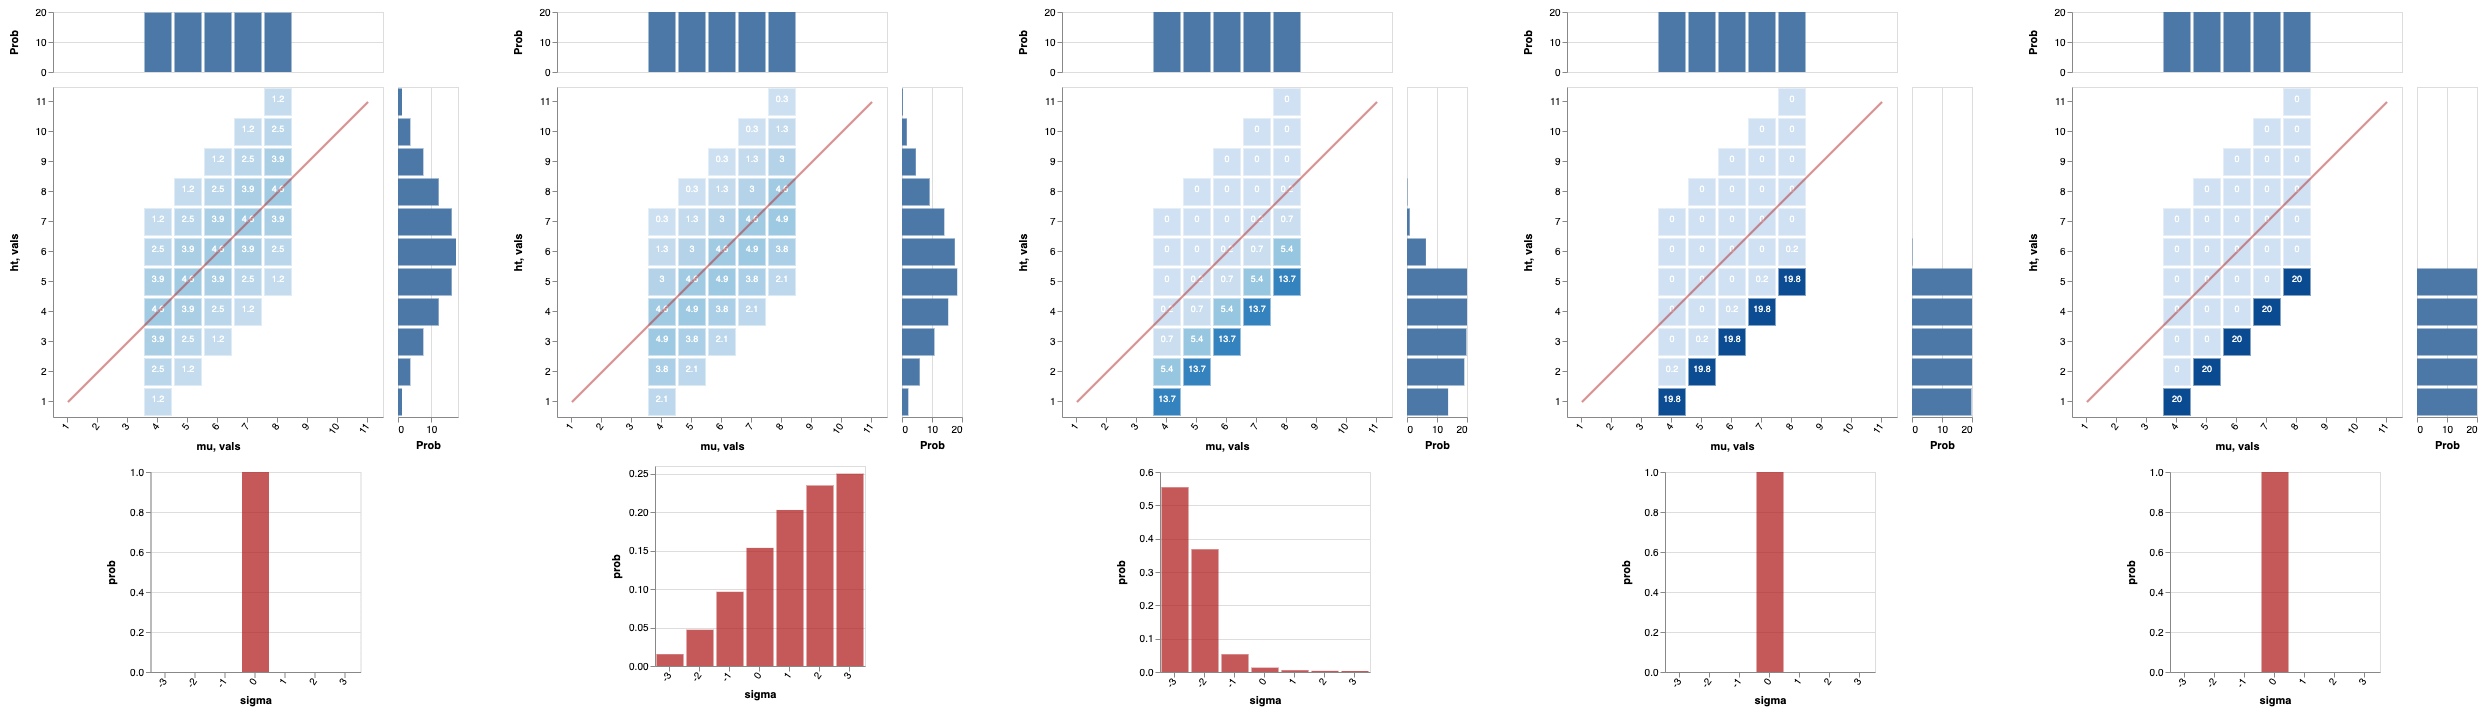

In [38]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUM cacheRef (0, UShrt, den0)
  , lp infoLUM >>= \l -> listener infoLUM cacheRef (0, UShrt, l)
  , listener infoLUM cacheRef (1, UShrt, den0)
  , listener infoLUM cacheRef (2, UShrt, den0)
  , listener infoLUM cacheRef (3, UShrt, den0)
  ]

## Degree demonstrative

All adjectival utterances are now interpreted as entailing that John's height is 6

In the baseline lexicon `denExact0`, this is all that is contributed by an utterance

Other interpretations place John's height at 6 and additionally guarantee that John's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John is 6-tall}]\!]_{\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = 6 \land 6 \geq \mu + \sigma\end{equation}

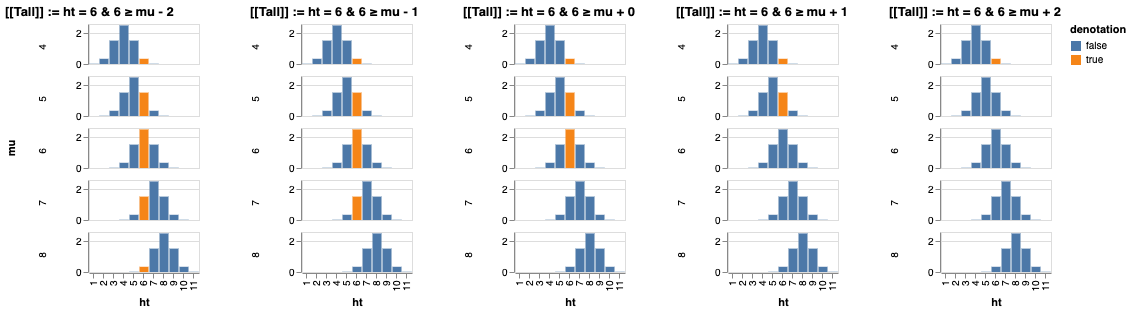

In [25]:
readFile "exactDens.vl" >>= \js -> pure (Display [vegalite js])

In [26]:
denExact0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w == 6) indices
        f UShrt = filter (\(w,i) -> ht w == 6) indices

exactDens :: [Lexicon]
exactDens = 
  do d <- [-sigma .. sigma] :: [Int]
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w == 6 && 6 >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w == 6 && 6 <= i + d) indices
     return (Lex d f)

### Pragmatic agents

#### Pragmatic listener hears

> "Bill's height is 6; John is that tall too"

Consider a listener that is not settled on one of these stengthenings

In [27]:
infoLUMExact = infoBaseline {lp = unif exactDens}

Of course since all of the lexica entail that John's height is 6, the distribution over worlds is completely determinate

The various conceivable strengthenings lead ultimately to a pragmatic conclusion that 6 is probably normal for the height of someone like John (this was already guaranteed by the prior), but it's possible that 6 is relatively high compared to the median

So to the extent that this is an evaluative conclusion, it is very weak

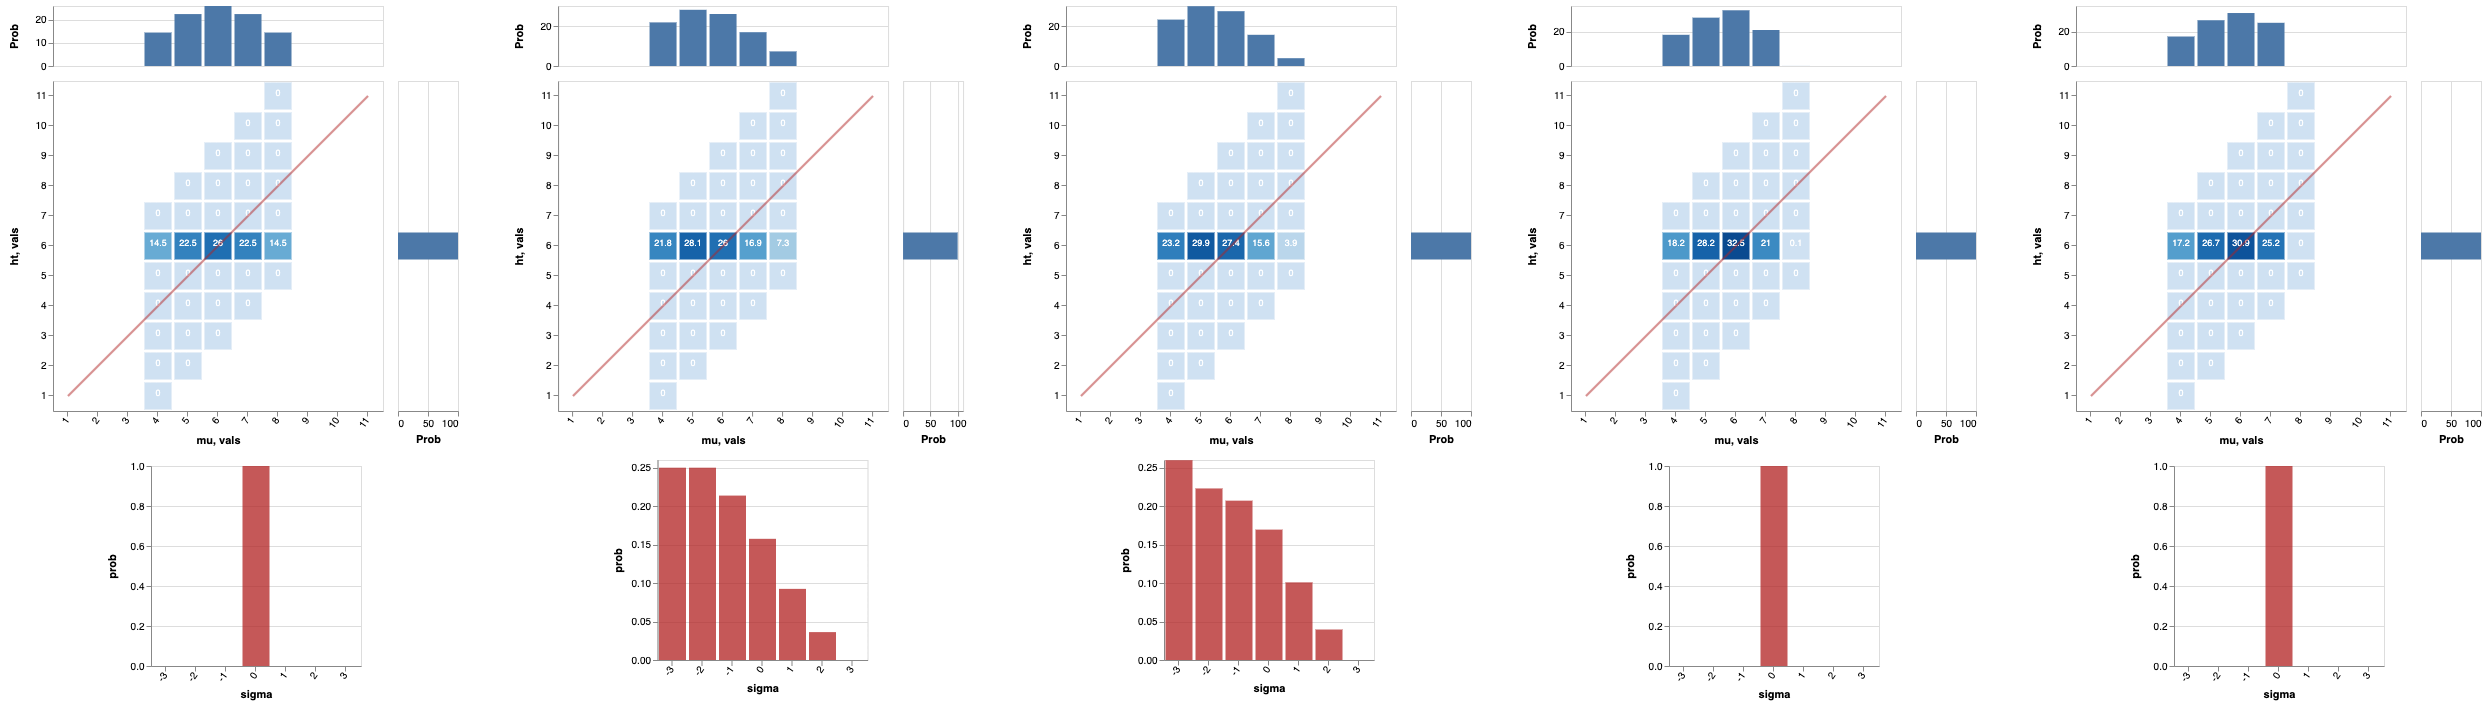

In [39]:
writeIORef cacheRef (0, Map.empty)
 
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMExact cacheRef (0, UTall, denExact0)
  , lp infoLUMExact>>= \l -> listener infoLUMExact cacheRef (0, UTall, l)
  , listener infoLUMExact cacheRef (1, UTall, denExact0)
  , listener infoLUMExact cacheRef (2, UTall, denExact0)
  , listener infoLUMExact cacheRef (3, UTall, denExact0)
  ]

#### Pragmatic listener hears:

> "Bill's height is 6; John is that short too"

Again, since the lexica all entail that a "6-short person" has height 6, the distribution over worlds is certain

But now, the various strengthenings lead ultimately to a pragmatic conclusion that 6 is almost certainly below the median

So again the evaluativity effect is much stronger

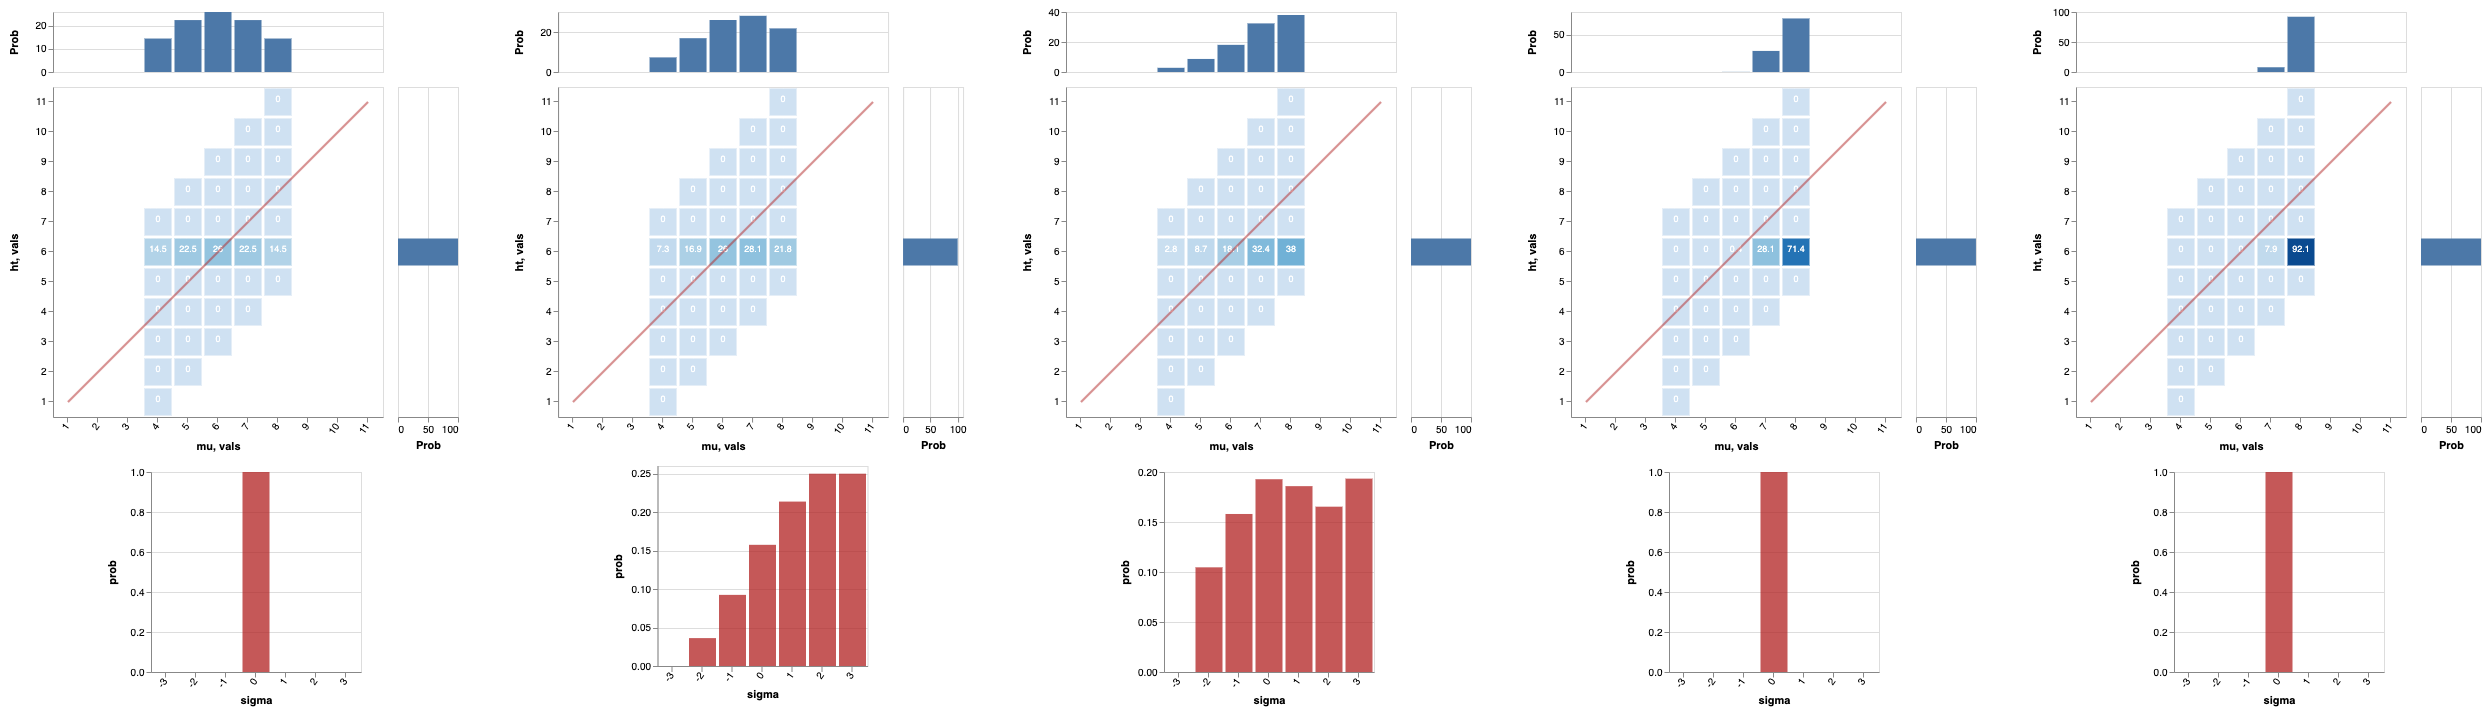

In [40]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLUMExact cacheRef (0, UShrt, denExact0)
  , lp infoLUMExact>>= \l -> listener infoLUMExact cacheRef (0, UShrt, l)
  , listener infoLUMExact cacheRef (1, UShrt, denExact0)
  , listener infoLUMExact cacheRef (2, UShrt, denExact0)
  , listener infoLUMExact cacheRef (3, UShrt, denExact0)
  ]

## Uncertain Equative

All adjectival utterances are now interpreted as entailing that John's height is equal to Bill's height, but Bill's height is unknown

There is no real baseline here, since there is no privileged belief for Bill's height, but let's arbitrarily set it at $6$.

Other interpretations place John's height at other values, and additionally guarantee that John's height is within a certain upper/lower percentile of the comparison class

\begin{equation}[\![\text{John is Bill-tall}]\!]_{b,\sigma} := \lambda \langle w,\mu\rangle.\, \textsf{ht}_w(\textsf{j}) = b \land b \geq \mu + \sigma\end{equation}

[eqDens in pictures](eqDens.vl)

In [30]:
denEq0 = Lex 0 f
  where f UNone = indices
        f UTall = filter (\(w,i) -> ht w == 6) indices
        f UShrt = filter (\(w,i) -> ht w == 6) indices

eqDens :: [Lexicon]
eqDens = 
  do d <- [-sigma .. sigma] :: [Int]
     b <- [4 .. 8]
     let f UNone = indices
         f UTall = filter (\(w,i) -> ht w == b && b >= i + d) indices
         f UShrt = filter (\(w,i) -> ht w == b && b <= i + d) indices
     return (Lex (d * 10 + b) f)

### Pragmatic agents

#### Pragmatic listener hears

> "John is as tall as Bill"

Cutting to the chase, consider a listener that is not settled on one of these stengthenings

In [31]:
infoLUMEq = infoBaseline {lp = unif eqDens}

Because Bill's height is unknown, the literal (and pragmatic) posterior over worlds is spread out

The various conceivable interpretations lead ultimately to a pragmatic conclusion that John is probably above the median, though not by much.

As before, we see a relatively weak evaluativity effect

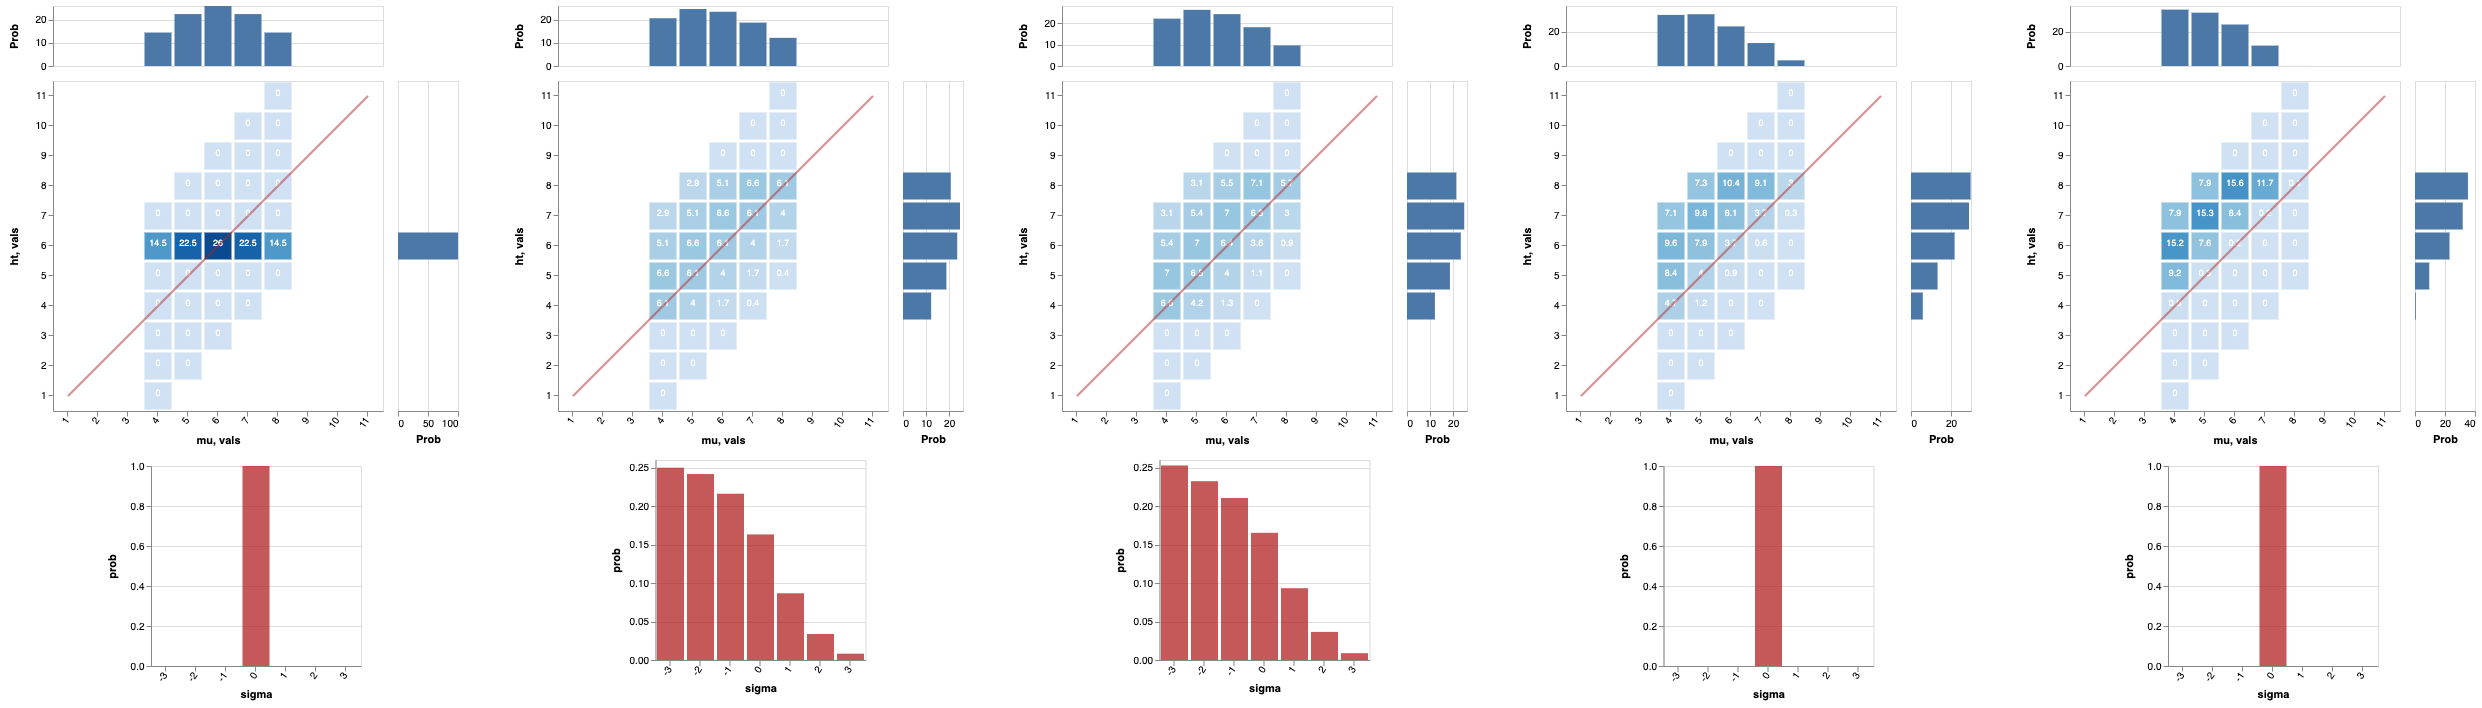

In [41]:
writeIORef cacheRef (0, Map.empty)

mkEqGraph m = do
  heat <- enumD (first ht              . fst <$> m)
  bar  <- enumD (floor . (/10) . fromIntegral . lexID . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
    ]

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMEq cacheRef (0, UTall, denEq0)
  , lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UTall, l)
  , listener infoLUMEq cacheRef (1, UTall, denEq0)
  , listener infoLUMEq cacheRef (2, UTall, denEq0)
  , listener infoLUMEq cacheRef (3, UTall, denEq0)
  ]

#### Pragmatic listener hears:

> "John is as short as Bill"

Again, since Bill's height is unknown, the posterior probability remains distributed across many heights

But now, the various strengthenings lead ultimately to a pragmatic conclusion that John is almost certainly below the median (same for Mary)

And as expected, the evaluativity effect is much stronger

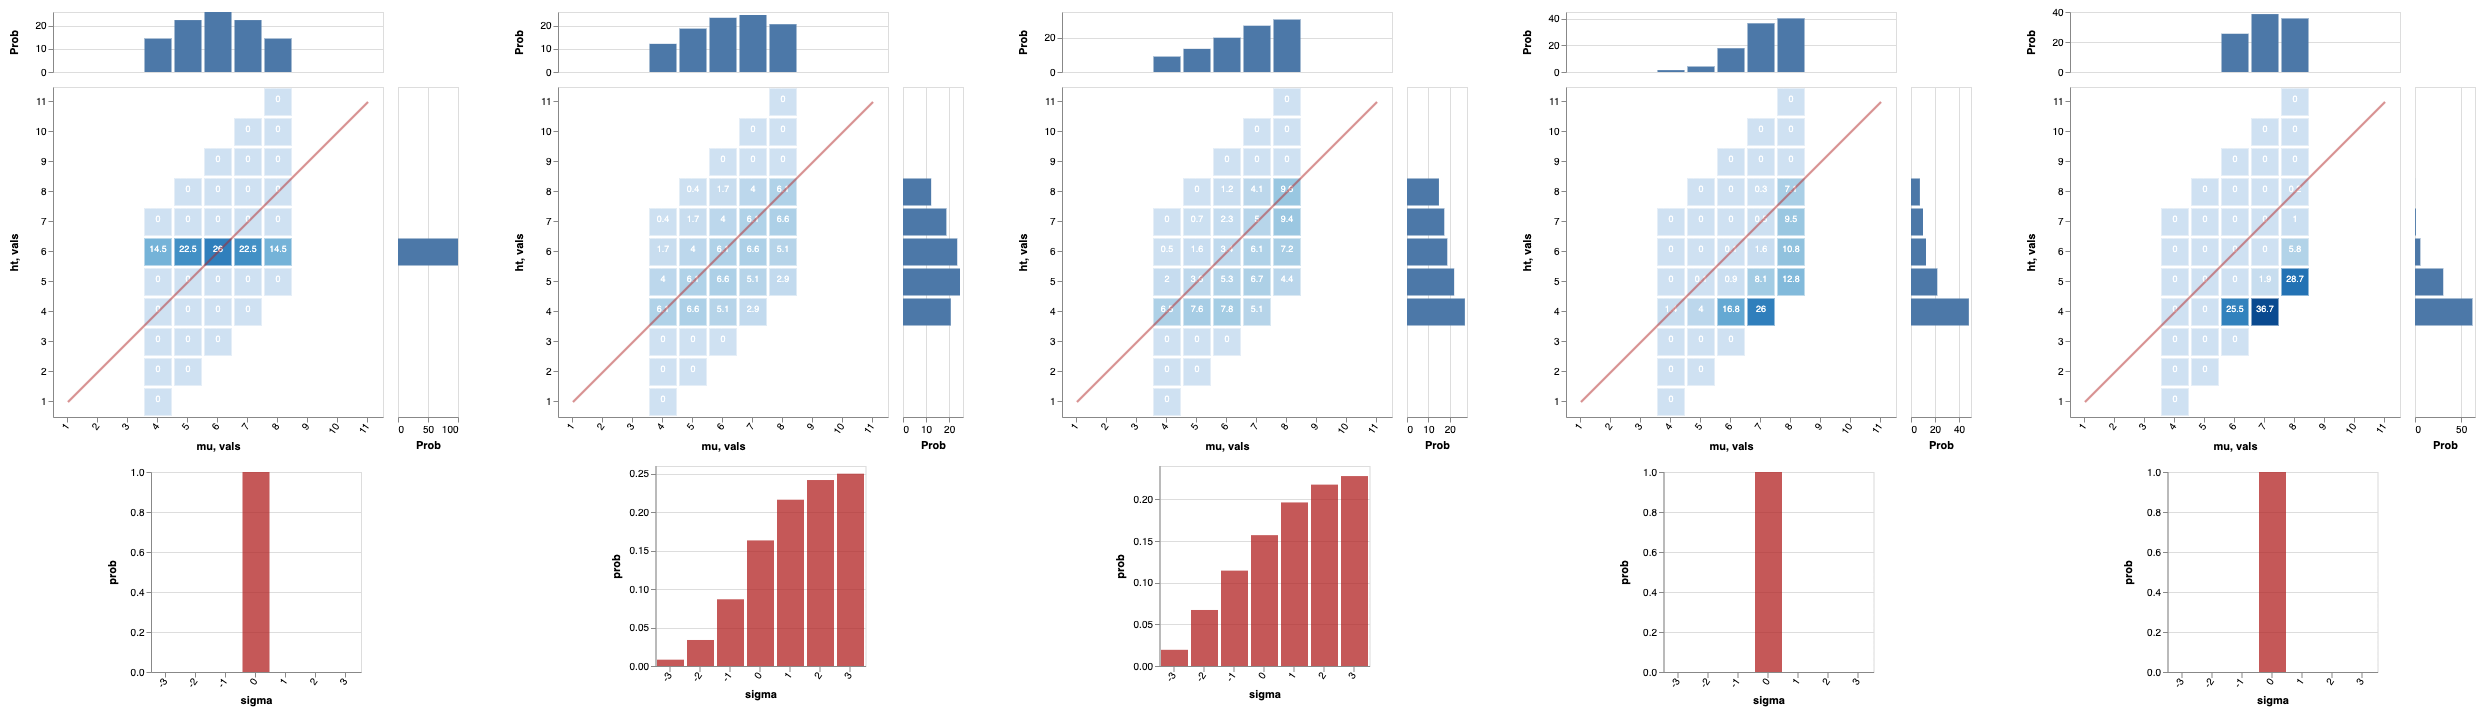

In [42]:
writeIORef cacheRef (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkEqGraph
  [ listener infoLUMEq cacheRef (0, UShrt, denEq0)
  , lp infoLUMEq >>= \l -> listener infoLUMEq cacheRef (0, UShrt, l)
  , listener infoLUMEq cacheRef (1, UShrt, denEq0)
  , listener infoLUMEq cacheRef (2, UShrt, denEq0)
  , listener infoLUMEq cacheRef (3, UShrt, denEq0)
  ]